In [1]:
import sys
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
from pathlib import Path
import os
import shutil
import numpy as np
from numpy.random import default_rng
#from deconv import REGISTRY
from utils import create_subsampled_images
import timeit
import tifffile as tif

In [2]:
import seaborn as sns
import pandas as pd
from nutil.plot import paperStyle
import matplotlib.pyplot as plt

In [16]:
# Randomly select 5 images
f = [f for f in os.listdir(data_path) if f.endswith('.tif')]

rng = default_rng(5678)
idx = rng.choice(len(f), size=len(f), replace=False)
idx_train =idx[5:]
idx_test = idx[0:5]
f_test = [f[i] for i in idx_test]
f_train = [f[i] for i in idx_train]
print(idx)
print(f_test)

[ 0  1 19  7 17 11  8 18 10  4 14  9 15  6 20 12  2 16 13  5  3]
['Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif', 'Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A3.tif', 'Alessandro_530_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A5.tif', 'Alessandro_512_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif', 'Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A3.tif']


In [17]:
Path(train_path_d).mkdir(parents=True, exist_ok=True)
Path(test_path_d).mkdir(parents=True, exist_ok=True)
Path(train_path_r).mkdir(parents=True, exist_ok=True)
Path(test_path_r).mkdir(parents=True, exist_ok=True)

for i in range(len(f)):
    src_d = os.path.join(data_path, f[i])
    src_r = os.path.join(raw_data_path, f[i])
    if i in idx_train:
        dst_d = train_path_d
        dst_r = train_path_r
    else:
        dst_d = test_path_d
        dst_r = test_path_r
    shutil.copy2(src_d, dst_d)
    shutil.copy2(src_r, dst_r)

## Timing Prediction

In [3]:
create_subsampled_images('D:/jo77pihe/Registered/20220203_Raw_80', 
                         'D:/jo77pihe/Registered/20220223_Subsampled/10_128', z_shape=10, xy_factor=4)
create_subsampled_images('D:/jo77pihe/Registered/20220203_Raw_80', 
                         'D:/jo77pihe/Registered/20220223_Subsampled/20_256', z_shape=20, xy_factor=2)
create_subsampled_images('D:/jo77pihe/Registered/20220203_Raw_80', 
                         'D:/jo77pihe/Registered/20220223_Subsampled/20_512', z_shape=20, xy_factor=1)
create_subsampled_images('D:/jo77pihe/Registered/20220203_Raw_80', 
                         'D:/jo77pihe/Registered/20220223_Subsampled/40_512', z_shape=40, xy_factor=1)
create_subsampled_images('D:/jo77pihe/Registered/20220203_Raw_80', 
                         'D:/jo77pihe/Registered/20220223_Subsampled/80_512', z_shape=80, xy_factor=1)

In [3]:
p1='D:/jo77pihe/Registered/20220223_Subsampled/10_128'
p2='D:/jo77pihe/Registered/20220223_Subsampled/20_256'
p3='D:/jo77pihe/Registered/20220223_Subsampled/20_512'
p4='D:/jo77pihe/Registered/20220223_Subsampled/40_512'
p5='D:/jo77pihe/Registered/20220223_Subsampled/80_512'
ps=[p1,p2,p3,p4,p5]


In [9]:
def predict_brl(args, it=(5,3,1), parallel=False):
    deconvolver=REGISTRY['BlindRL'](args)
    if parallel:
        start = timeit.default_timer()
        deconvolver.predict(args['source_folder'], 5, 1, 3, 1, eval_img_steps = False, save_intermediate_res= False,
                         parallel=parallel, plot_frequency=5)
        t=timeit.default_timer()-start

    else:
        start = timeit.default_timer()
        deconvolver.predict_seq(args['source_folder'], 5, 1, 3, 1, eval_img_steps = False, save_intermediate_res= False,
                         parallel=parallel, plot_frequency=5)
        t=timeit.default_timer()-start
    return t


In [4]:
args = {}
args['data_path']= ''
args['target_folder']= ''
args['result_path'] = 'Blind_RL_Test'
args['psf'] = "C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/PSF"

In [12]:
t_brl=np.zeros((10,1))
for (ip,p) in enumerate(ps):
    args['source_folder']= p1
    args['result_path'] = p1 + 'results'

    t_brl[ip*2,:]=predict_brl(args, it=(5,3,1), parallel=False)
    t_brl[ip*2+1,:]=predict_brl(args, it=(5,3,1), parallel=True)

In [5]:
t_brl

array([[  39.5967044],
       [  14.3252129],
       [ 191.8395826],
       [  55.3395331],
       [ 716.38238  ],
       [ 204.0918666],
       [1308.7466843],
       [ 330.9355536],
       [2354.3035076],
       [ 564.0222814]])

In [9]:
np.save('timing_deconv.npy', t_brl)

In [3]:
t_brl=np.load('timing_deconv.npy')

In [4]:
t_p=t_brl[1::2]

In [5]:
t_np=t_brl[::2]

In [6]:
t_p

array([[ 14.3252129],
       [ 55.3395331],
       [204.0918666],
       [330.9355536],
       [564.0222814]])

In [7]:
t_np

array([[  39.5967044],
       [ 191.8395826],
       [ 716.38238  ],
       [1308.7466843],
       [2354.3035076]])

## CARE

In [3]:
d_care='D:/jo77pihe/Registered/20220207_CARE_HypTuning/Trial_8_32_16_0.0004_True'
model_appendix = 'models/my_model'
parts = d_care.split('_')
args = {}
args['z_shape'] = parts[1]
args['xy_shape'] = parts[2]
t_care=np.zeros((5,1))

In [4]:
def predict_care(args, img_idx=None):
    deconvolver = REGISTRY['csbdeep'](args)
    if img_idx is None:
        start = timeit.default_timer()
        deconvolver.predict(args['data_path'],model_dir=d_care,name=os.path.join(d_care,model_appendix),
                                    res_folder=args['result_path'])
        t=timeit.default_timer()-start
    else:
        files = [f for f in os.listdir(args['data_path']) if f.endswith('.tif')]
        start = timeit.default_timer()
        X=tif.imread(os.path.join(args['data_path'],files[idx]))
        deconvolver.predict_img(X,model_dir=d_care,name=os.path.join(d_care,model_appendix),
                                    save_as=os.path.join(args['result_path'], files[idx]))
        t=timeit.default_timer()-start        

    return t

In [27]:
t_care=np.load('timing_deconv_care.npy')

In [ ]:
for (ip,p) in enumerate(ps):
    if ip==3:
        args['data_path'] = p
        args['result_path'] = p + 'results_care'
        t_care[ip,0]=predict_care(args)

Loading network weights from 'weights_best.h5'.


In [7]:
idx=3
for (ip,p) in enumerate(ps):
    if ip==4:
        args['data_path'] = p
        args['result_path'] = p + 'results_care'
        t_care[ip,0]+=predict_care(args, idx)

Loading network weights from 'weights_best.h5'.


In [8]:
t_care

array([[ 0.7666194],
       [ 1.4335475],
       [ 3.5865564],
       [45.5147812],
       [65.3783655]])

In [9]:
np.save('timing_deconv_care.npy', t_care)

In [11]:
t_care = np.load('timing_deconv_care.npy')

## Mu-Net

In [12]:
ptrial='Trial_3_16_64_0.001_16'
d_mu=os.path.join('D:/jo77pihe/Registered/20220214_Mu-Net', ptrial)
parts = ptrial.split('_')
args = {}
args['z_shape'] = int(parts[2])
args['xy_shape'] = int(parts[3])
args['n_levels'] = int(parts[1])

In [19]:
args = {}

args['source_folder'] = 'Raw'
args['target_folder'] = 'Deconved'
args['batch_size'] = int(parts[5])
args['n_patches']=100


In [20]:
def predict_mu(args):
    deconvolver = REGISTRY['mu-net'](args)
    deconvolver.res_path =args['result_path']
    start = timeit.default_timer()
    deconvolver.predict(args['data_path'],os.path.join(d_mu, 'model'))
    t=timeit.default_timer()-start

    return t

In [21]:
t_mu=np.zeros((5,1))
for (ip,p) in enumerate(ps):
    args['data_path'] = p
    args['result_path'] = p + 'results_mu'
    
    t_mu[ip,0]=predict_mu(args)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000002CF615938E0>>


AttributeError: module 'flammkuchen' has no attribute 'meta'

In [ ]:
t_mu[0,0]=37.257702800000004
t_mu[1,0]=281.9525577
t_mu[2,0]=1133.0619605000002

In [28]:
t_mu16=np.zeros((5,1))
t_mu16[0,0]=38.7862746
t_mu16[1,0]=284.6584509
t_mu16[2,0]=1100.5143818
t_mu16[3,0]=2222.3461059
t_mu16[4,0]=4917.648438200001

## AutoQuant

In [8]:
t_aq = np.zeros((5,1))
t_aq[0,0]=2.63*4
t_aq[1,0]=6.90*4
t_aq[2,0]=22.37*4
t_aq[3,0]=39.10*4
t_aq[4,0]=63.1*4


In [9]:
t_aq

array([[ 10.52],
       [ 27.6 ],
       [ 89.48],
       [156.4 ],
       [252.4 ]])

## Comparison

### Timing

In [30]:
labs=['AutoQuant']*5+['$BRL_{Seq}$']*5+['$BRL_{Par}$']*5 +['CARE']*5+ ['Mu-Net']*5
size=['10x128x128','20x256x256','20x512x512','40x512x512','80x512x512']
size = size+size+size+size+size
t = np.append(t_aq,t_np)
t = np.append(t,t_p)
t= np.append(t,t_care)
t= np.append(t,t_mu16)

In [31]:
d = {'Time [s]': t, 'Size': size, 'Algorithm': labs}
dfx = pd.DataFrame(data=d)

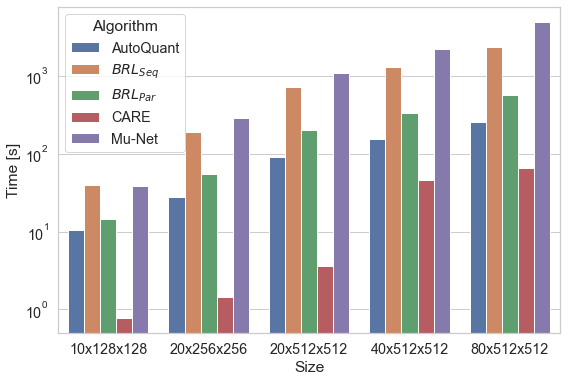

In [36]:
with paperStyle():
    sns.set(style="whitegrid",rc={'figure.figsize':(9,6)}, font_scale=1.3)
    ax = sns.barplot(x="Size", y="Time [s]", hue="Algorithm", data=dfx)
    ax.set_yscale("log")
    #for container in ax.containers:
     #   ax.bar_label(container)
plt.savefig('timing_deconv.svg',bbox_inches='tight')
plt.savefig('timing_deconv.pdf',bbox_inches='tight')

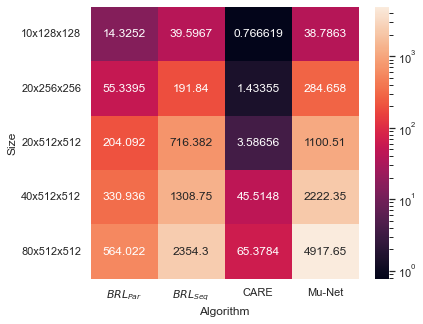

In [65]:
from matplotlib.colors import LogNorm, Normalize
p = df.pivot("Size", "Algorithm", "Time [s]")
with paperStyle():
    sns.set(rc={'figure.figsize':(6,5)})
    ax = sns.heatmap(p, annot=True, norm=LogNorm(), fmt='g')

#plt.savefig('timing_deconv.svg',bbox_inches='tight')
#plt.savefig('timing_deconv.pdf',bbox_inches='tight')

In [ ]:
t = np.append(t_np,t_p)
t= np.append(t,t_care)
t= np.append(t,t_mu16)

### Image Quality

In [55]:
import tifffile as tif
import sys
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
import utils
import normalize
import imagequalitymetrics
import os
import numpy as np
import pandas as pd
from nutil.plot import paperStyle
import seaborn as sns
import matplotlib.pyplot as plt
from pystackreg import StackReg
import matplotlib as mpl

In [41]:
path = 'D:/jo77pihe/Registered/20220223_Deconv_comp'
care_path = os.path.join(path, 'CARE')
mun_path = os.path.join(path, 'MuNet')
brl_path = os.path.join(path, 'BlindRL')
aq_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_NotAveraged'
files = [f for f in os.listdir(mun_path) if f.endswith('.tif')]
prefix = '531'
normalizer = normalize.PercentileNormalizer()
rescaler = normalize.Rescaler()
iqm = imagequalitymetrics.ImageQualityMetrics()

In [42]:
labs = []
res=[]
for f in files:
    gt = tif.imread(os.path.join(aq_path, f))
    print(np.min(gt), np.max(gt))
    
    care = tif.imread(os.path.join(care_path, f))
    mun = tif.imread(os.path.join(mun_path, f))
    brl = tif.imread(os.path.join(brl_path, prefix+f))

    gt = normalizer.normalize(gt)
    care = normalizer.normalize(care)#, np.min(gt), np.max(gt))
    mun = normalizer.normalize(mun)#, np.min(gt), np.max(gt))
    brl = normalizer.normalize(brl)#, np.min(gt), np.max(gt))
    print(np.min(gt), np.max(gt))
    print(np.min(care), np.max(care))
    print(np.min(mun), np.max(mun))
    print(np.min(brl), np.max(brl))
    
    brlr = np.zeros(brl.shape)
    for i in range(brl.shape[0]):
        sr = StackReg(StackReg.BILINEAR)
        x =brl[i,:,:]
        y = x.copy()
        out_sca = sr.register_transform(gt[i,:,:],x )
        # print(x==y)
        # y=sr.transform_stack(y, tmats=out_sca)
        # print(x==y)
        brlr[i,:,:] = out_sca

    res.append(iqm.ssim(care,gt))
    labs.append('CARE')
    res.append(iqm.ssim(mun,gt))
    labs.append('Mu-Net')
    res.append(iqm.ssim(brlr,gt))
    labs.append('BRL')

0.32333437 15682.505
-0.0020749941 1.7185017
-0.10623389 2.382992
-0.047908716 1.3834704
-2.4961795e-13 1.6906681


C:\Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites\imagequalitymetrics.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  val = sk_ssim(img, gt_img)


0.02118058 18489.117
-0.00068984926 1.7825803
-0.08916519 1.7144552
-0.022734622 1.4535161
-2.5138066e-08 1.3923645
4.37735 16287.4
-0.011007265 1.579821
-0.35109168 1.5384177
-0.07607726 1.7125624
-0.00026291332 1.3403722
2.748661 11711.335
-0.007758038 1.4838717
-0.12143288 1.5010811
-0.052183677 1.5491889
-1.8134388e-05 1.513922
1.7636301e-05 14331.845
-2.7728824e-05 1.5340887
-0.059987888 1.3515006
-0.01920225 1.4425559
-0.00049220346 1.4126047


In [43]:
d = {'Algorithm': labs, 'SSIM': res}
df = pd.DataFrame(data=d)

In [44]:
pd.to_pickle(df, 'deconv_comp_ssim.pkl')

In [19]:
df=pd.read_pickle('deconv_comp_ssim.pkl')

In [15]:
df

,Algorithm,SSIM
0,CARE,0.859559
1,Mu-Net,0.762044
2,BRL,0.916450
3,CARE,0.887176
4,Mu-Net,0.782416
5,BRL,0.934620
6,CARE,0.732887
7,Mu-Net,0.630679
8,BRL,0.813122
9,CARE,0.839364


In [19]:
np_ssim=np.array(df['SSIM'])
np.mean(np_ssim[1::3])

0.7529731874995278

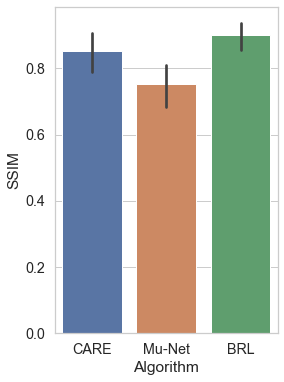

In [38]:
with paperStyle(20):
    sns.set(style="whitegrid",rc={'figure.figsize':(4,6)}, font_scale=1.3)
    ax = sns.barplot(x="Algorithm", y="SSIM", data=df)
    #for container in ax.containers:
     #   ax.bar_label(container)
plt.savefig('ssim_deconv.svg',bbox_inches='tight')
plt.savefig('ssim_deconv.pdf',bbox_inches='tight')

### Visual

Alessandro_530_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A6.tif
0.00039016004 12471.621


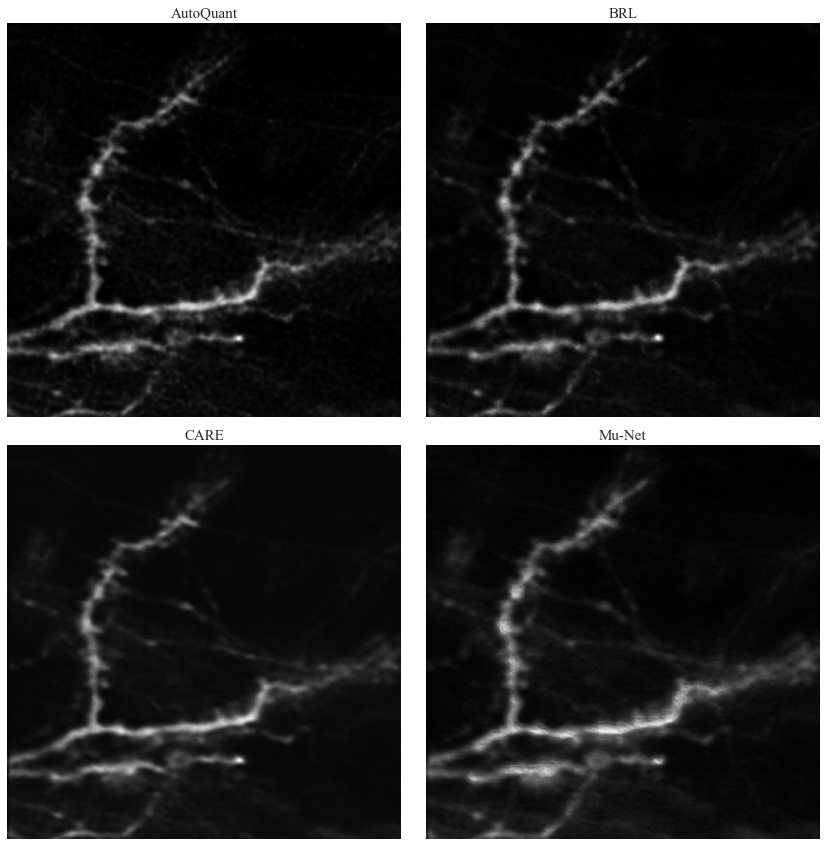

In [86]:
img1 = 'Alessandro_530_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A6.tif'
plane = 15
prefix='531'
with paperStyle():
    mpl.rcParams['axes.titlesize'] = 15
    plt.rcParams['font.family'] = 'Times New Roman'
 

    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    n_h = 2
    n_w = 2
    #AQ
    f = tif.imread(os.path.join(aq_path, img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray')#, vmin = 0, vmax = 25000.996)
    ax.set_title('AutoQuant')
    ax.axis('off')
    print(f[plane, :, :].min(), f[plane, :, :].max())

    # BRL
    f = tif.imread(os.path.join(brl_path, prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('BRL')
    ax.axis('off')

    #CARE
    f = tif.imread(os.path.join(care_path, img1))
    ax = fig.add_subplot(n_h, n_w, 3)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('CARE')
    ax.axis('off')

    # MUN
    f = tif.imread(os.path.join(mun_path, img1))
    ax = fig.add_subplot(n_h, n_w, 4)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('Mu-Net')
    ax.axis('off')


    plt.subplots_adjust(wspace=0.001, hspace=0.07)

plt.savefig('Deconv_visual_inspection.svg',bbox_inches='tight')
plt.savefig('Deconv_visual_inspection.pdf',bbox_inches='tight')

Alessandro_512_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A1.tif
96.98289 9903.285
-141.62042 11053.105


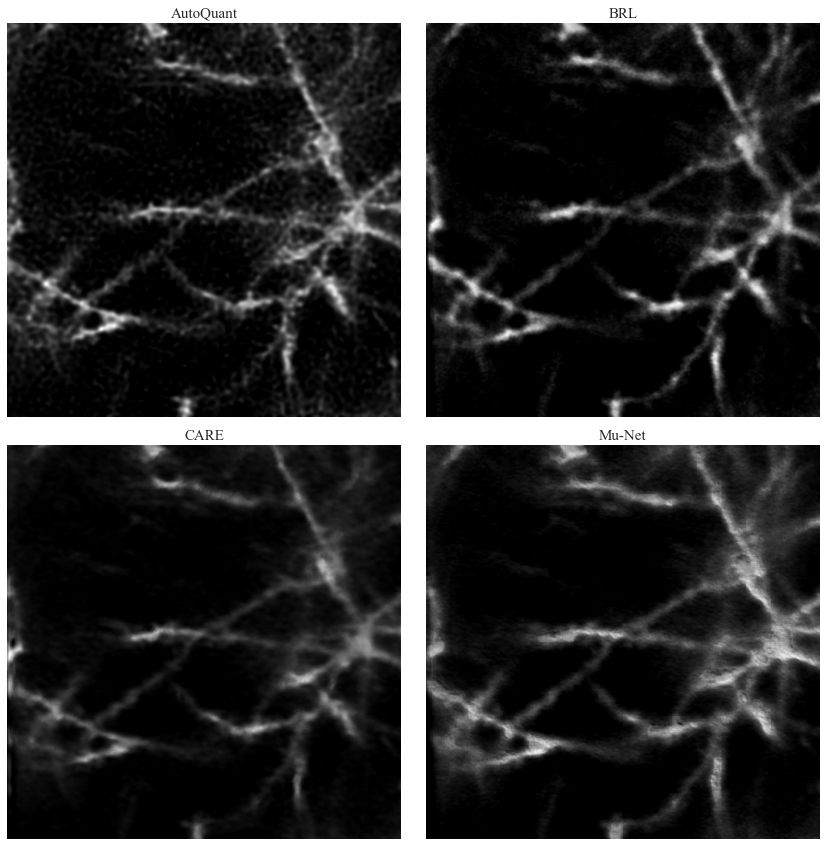

In [85]:
img1 = 'Alessandro_512_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A1.tif'
plane = 9
prefix='531'
with paperStyle():
    mpl.rcParams['axes.titlesize'] = 15
    plt.rcParams['font.family'] = 'Times New Roman'
 

    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    n_h = 2
    n_w = 2
    #AQ
    f = tif.imread(os.path.join(aq_path, img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray', vmin = 700, vmax = 9903)
    ax.set_title('AutoQuant')
    ax.axis('off')
    print(f[plane, :, :].min(), f[plane, :, :].max())

    # BRL
    f = tif.imread(os.path.join(brl_path, prefix+img1))

    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray', vmin = 2.0583394e-6, vmax = 2.4925444e-05)
    ax.set_title('BRL')
    ax.axis('off')

    #CARE
    f = tif.imread(os.path.join(care_path, img1))
    print(f[plane, :, :].min(), f[plane, :, :].max())

    ax = fig.add_subplot(n_h, n_w, 3)
    ax.imshow(f[plane, :, :],cmap='gray', vmin = 500, vmax = 11053)
    ax.set_title('CARE')
    ax.axis('off')

    # MUN
    f = tif.imread(os.path.join(mun_path, img1))
    ax = fig.add_subplot(n_h, n_w, 4)
    ax.imshow(f[plane, :, :],cmap='gray', vmin = 3000, vmax = 8391)
    ax.set_title('Mu-Net')
    ax.axis('off')


    plt.subplots_adjust(wspace=0.001, hspace=0.07)

plt.savefig('Deconv_visual_inspection1.svg',bbox_inches='tight')
plt.savefig('Deconv_visual_inspection1.pdf',bbox_inches='tight')